# GAN by Pytorch for generaate fasion

## Load module

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

## Define parameter

In [32]:
# Hyperparameters
noise_dim = 100
img_rows, img_cols, channels = 28, 28, 1
batch_size = 64
epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
dataset_path = '../datasets/fashion_mnist'

Using device: cuda


## Create model

### Define Generator

In [3]:
class Generator(nn.Module):
    def __init__(self, noise_dim, channels):
        super(Generator, self).__init__()
        
        self.init_size = img_rows // 4   # 28/4 = 7
        self.fc = nn.Sequential(
            nn.Linear(noise_dim, 128 * self.init_size * self.init_size),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self.conv_blocks = nn.Sequential(
            # 7x7x128 -> 14x14x128
            nn.ConvTranspose2d(128, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            
            # 14x14x128 -> 28x28x64
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            
            # 28x28x64 -> 28x28x1
            nn.Conv2d(64, channels, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )
        
    def forward(self, z):
        out = self.fc(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)  # reshape
        img = self.conv_blocks(out)
        return img



### Define Discrimer

In [4]:
class Discriminator(nn.Module):
    def __init__(self, channels):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            # 28x28x1 -> 28x28x64
            nn.Conv2d(channels, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            
            # 28x28x64 -> 14x14x128
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(128 * (img_rows//2) * (img_cols//2), 1),
            nn.Sigmoid()
        )
    
    def forward(self, img):
        return self.model(img)

### Create instance

In [5]:
generator = Generator(noise_dim, channels).to(device)
discriminator = Discriminator(channels).to(device)

# Loss and optimizers
adversarial_loss = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

## Load dataset

In [6]:
# Load Fashion-MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Scale to [-1, 1]
])
dataset = datasets.FashionMNIST(root=dataset_path, train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 26.4M/26.4M [00:17<00:00, 1.51MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 52.5kB/s]
100%|██████████| 4.42M/4.42M [00:02<00:00, 1.64MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 27.9kB/s]


## Train model

In [9]:
from tqdm import tqdm

for epoch in range(epochs):
    for step, (real_imgs, _) in enumerate(tqdm(dataloader)):
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)

        # Adversarial labels
        valid = torch.ones((batch_size, 1), device=device) * 0.9   # label smoothing
        fake = torch.zeros((batch_size, 1), device=device)

        # ---------------------
        # Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        # Real images
        real_loss = adversarial_loss(discriminator(real_imgs), valid)

        # Fake images
        z = torch.randn(batch_size, noise_dim, device=device)
        gen_imgs = generator(z)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)

        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # -----------------
        # Train Generator
        # -----------------
        optimizer_G.zero_grad()

        # Generator tries to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), torch.ones((batch_size, 1), device=device))
        g_loss.backward()
        optimizer_G.step()

    print(f"Epoch {epoch+1}/{epochs}, Step {step+1}, D loss: {d_loss.item():.4f}, G loss: {g_loss.item():.4f}")


100%|██████████| 938/938 [00:17<00:00, 52.43it/s]


Epoch 1/50, Step 938, D loss: 0.1672, G loss: 6.1462


100%|██████████| 938/938 [00:17<00:00, 54.69it/s]


Epoch 2/50, Step 938, D loss: 0.1659, G loss: 6.4496


100%|██████████| 938/938 [00:17<00:00, 52.56it/s]


Epoch 3/50, Step 938, D loss: 0.1647, G loss: 6.4647


100%|██████████| 938/938 [00:17<00:00, 52.24it/s]


Epoch 4/50, Step 938, D loss: 0.1642, G loss: 7.4229


100%|██████████| 938/938 [00:17<00:00, 53.89it/s]


Epoch 5/50, Step 938, D loss: 0.1635, G loss: 7.8147


100%|██████████| 938/938 [00:17<00:00, 53.55it/s]


Epoch 6/50, Step 938, D loss: 0.1638, G loss: 7.6202


100%|██████████| 938/938 [00:17<00:00, 53.60it/s]


Epoch 7/50, Step 938, D loss: 0.1637, G loss: 7.2190


100%|██████████| 938/938 [00:17<00:00, 53.83it/s]


Epoch 8/50, Step 938, D loss: 0.1644, G loss: 7.5169


100%|██████████| 938/938 [00:17<00:00, 53.78it/s]


Epoch 9/50, Step 938, D loss: 0.1656, G loss: 6.3005


100%|██████████| 938/938 [00:17<00:00, 53.85it/s]


Epoch 10/50, Step 938, D loss: 0.1637, G loss: 7.3891


100%|██████████| 938/938 [00:17<00:00, 53.87it/s]


Epoch 11/50, Step 938, D loss: 0.1638, G loss: 7.2444


100%|██████████| 938/938 [00:17<00:00, 53.84it/s]


Epoch 12/50, Step 938, D loss: 0.1680, G loss: 7.6686


100%|██████████| 938/938 [00:17<00:00, 53.82it/s]


Epoch 13/50, Step 938, D loss: 0.1640, G loss: 7.4946


100%|██████████| 938/938 [00:17<00:00, 53.81it/s]


Epoch 14/50, Step 938, D loss: 0.1688, G loss: 6.2987


100%|██████████| 938/938 [00:17<00:00, 53.64it/s]


Epoch 15/50, Step 938, D loss: 0.1635, G loss: 7.9734


100%|██████████| 938/938 [00:17<00:00, 53.61it/s]


Epoch 16/50, Step 938, D loss: 0.1672, G loss: 6.3855


100%|██████████| 938/938 [00:17<00:00, 53.59it/s]


Epoch 17/50, Step 938, D loss: 0.1635, G loss: 7.4723


100%|██████████| 938/938 [00:17<00:00, 53.65it/s]


Epoch 18/50, Step 938, D loss: 0.1649, G loss: 6.3828


100%|██████████| 938/938 [00:17<00:00, 53.72it/s]


Epoch 19/50, Step 938, D loss: 0.1636, G loss: 7.8527


100%|██████████| 938/938 [00:17<00:00, 53.69it/s]


Epoch 20/50, Step 938, D loss: 0.1650, G loss: 8.3295


100%|██████████| 938/938 [00:17<00:00, 53.67it/s]


Epoch 21/50, Step 938, D loss: 0.1646, G loss: 6.2939


100%|██████████| 938/938 [00:17<00:00, 53.74it/s]


Epoch 22/50, Step 938, D loss: 0.1635, G loss: 7.8954


100%|██████████| 938/938 [00:17<00:00, 53.67it/s]


Epoch 23/50, Step 938, D loss: 0.1641, G loss: 7.5699


100%|██████████| 938/938 [00:17<00:00, 53.67it/s]


Epoch 24/50, Step 938, D loss: 0.1639, G loss: 8.1652


100%|██████████| 938/938 [00:17<00:00, 53.62it/s]


Epoch 25/50, Step 938, D loss: 0.1640, G loss: 7.4365


100%|██████████| 938/938 [00:17<00:00, 52.96it/s]


Epoch 26/50, Step 938, D loss: 0.1634, G loss: 8.0437


100%|██████████| 938/938 [00:17<00:00, 52.17it/s]


Epoch 27/50, Step 938, D loss: 0.1630, G loss: 8.5436


100%|██████████| 938/938 [00:17<00:00, 52.51it/s]


Epoch 28/50, Step 938, D loss: 0.1639, G loss: 7.6447


100%|██████████| 938/938 [00:17<00:00, 52.67it/s]


Epoch 29/50, Step 938, D loss: 0.1639, G loss: 7.6708


100%|██████████| 938/938 [00:17<00:00, 52.60it/s]


Epoch 30/50, Step 938, D loss: 0.1629, G loss: 8.1131


100%|██████████| 938/938 [00:17<00:00, 52.29it/s]


Epoch 31/50, Step 938, D loss: 0.1634, G loss: 7.8170


100%|██████████| 938/938 [00:17<00:00, 52.64it/s]


Epoch 32/50, Step 938, D loss: 0.1633, G loss: 8.2779


100%|██████████| 938/938 [00:17<00:00, 52.40it/s]


Epoch 33/50, Step 938, D loss: 0.6946, G loss: 1.3109


100%|██████████| 938/938 [00:17<00:00, 52.13it/s]


Epoch 34/50, Step 938, D loss: 0.4236, G loss: 1.9925


100%|██████████| 938/938 [00:18<00:00, 51.36it/s]


Epoch 35/50, Step 938, D loss: 0.5314, G loss: 1.4074


100%|██████████| 938/938 [00:17<00:00, 52.14it/s]


Epoch 36/50, Step 938, D loss: 0.4572, G loss: 1.5473


100%|██████████| 938/938 [00:17<00:00, 52.31it/s]


Epoch 37/50, Step 938, D loss: 0.5016, G loss: 1.4435


100%|██████████| 938/938 [00:17<00:00, 52.25it/s]


Epoch 38/50, Step 938, D loss: 0.5790, G loss: 1.3777


100%|██████████| 938/938 [00:17<00:00, 52.17it/s]


Epoch 39/50, Step 938, D loss: 0.5794, G loss: 1.2504


100%|██████████| 938/938 [00:17<00:00, 52.22it/s]


Epoch 40/50, Step 938, D loss: 0.5650, G loss: 1.2889


100%|██████████| 938/938 [00:18<00:00, 52.05it/s]


Epoch 41/50, Step 938, D loss: 0.5646, G loss: 1.2209


100%|██████████| 938/938 [00:17<00:00, 52.17it/s]


Epoch 42/50, Step 938, D loss: 0.5915, G loss: 1.1502


100%|██████████| 938/938 [00:17<00:00, 52.13it/s]


Epoch 43/50, Step 938, D loss: 0.5578, G loss: 1.6638


100%|██████████| 938/938 [00:17<00:00, 52.19it/s]


Epoch 44/50, Step 938, D loss: 0.6330, G loss: 1.1601


100%|██████████| 938/938 [00:17<00:00, 52.19it/s]


Epoch 45/50, Step 938, D loss: 0.5723, G loss: 1.1025


100%|██████████| 938/938 [00:18<00:00, 52.02it/s]


Epoch 46/50, Step 938, D loss: 0.6399, G loss: 1.5036


100%|██████████| 938/938 [00:18<00:00, 52.11it/s]


Epoch 47/50, Step 938, D loss: 0.5996, G loss: 1.1562


100%|██████████| 938/938 [00:18<00:00, 52.00it/s]


Epoch 48/50, Step 938, D loss: 0.6088, G loss: 1.0823


100%|██████████| 938/938 [00:18<00:00, 51.99it/s]


Epoch 49/50, Step 938, D loss: 0.6339, G loss: 1.1181


100%|██████████| 938/938 [00:18<00:00, 51.86it/s]

Epoch 50/50, Step 938, D loss: 0.6854, G loss: 1.1697


## Test generate

In [12]:
z = torch.randn(batch_size, noise_dim, device=device)
gen_imgs = generator(z)
print(type(gen_imgs), gen_imgs.shape)  # Check the generated images

<class 'torch.Tensor'> torch.Size([32, 1, 28, 28])


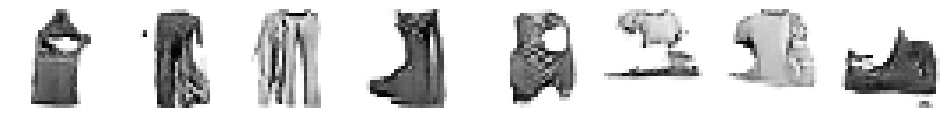

In [14]:
import matplotlib.pyplot as plt

# Move images to CPU and denormalize from [-1, 1] to [0, 1]
imgs = gen_imgs.detach().cpu()
imgs = (imgs + 1) / 2

fig, axes = plt.subplots(1, min(8, batch_size), figsize=(12, 2))
for i in range(min(8, batch_size)):
    axes[i].imshow(imgs[i][0], cmap='gray_r')
    axes[i].axis('off')
plt.show()

In [31]:
data_iter = iter(dataloader)
img, label = next(data_iter)
print(img.shape, label.shape)  # Check the shape of the images and labels
print(type(img.size(1)), img.size(3))  # Check the type and shape of the first generated image

torch.Size([64, 1, 28, 28]) torch.Size([64])
<class 'int'> 28
